# Intro

This is for preprocess dataset. There are steps we have:

## Audio preprocess

1. convert audios from wave to mel_spectrogram
2. convert audios from wave to spectrogram
3. globally normalize (mel-)spectrogram
4. filter sound then do transformation

## Load subset from entire dataset (for Frank)

In [2]:
import librosa
import pandas as pd
from librosa.util import index_to_slice
from scipy.signal import spectrogram

# meta data file (with syllable information)
import PretermDataLoader as dl
import audioPreprocess as ap
import random
import dataPreprocess as dp

metafile = 'guide_test_syllableInfor.pkl'
datanum = 10000 # assume that you want 10000 tokens

suids,padded_waves = dp.load_dataset('/mnt/storage/compling/proslearn/src/eng/guide_test_waves_padded.pkl')

KeyboardInterrupt: 

In [18]:
loader = dl.DataLoader()
meta = loader.get_metadata(metafile)

In [19]:
# you may randomly select certain number of data
mels,indexes = loader.load_data('mel',datanum)
spectrograms = loader.load_data('highpass_mel',datanum,indexes)[0]
soundpaths = [meta['filepath'][i] for i in indexes]

KeyboardInterrupt: 

/mnt/storage/compling/proslearn/src/data_construction/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


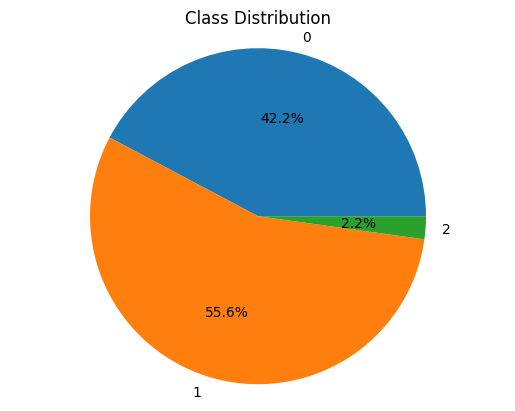

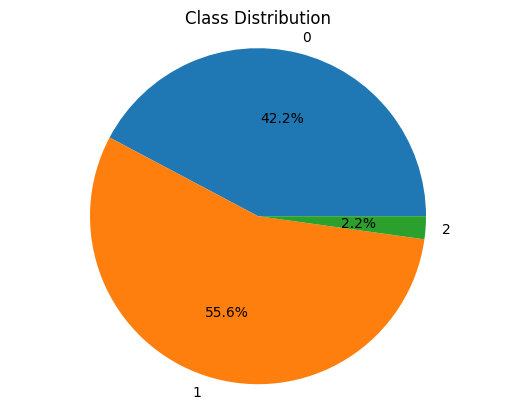

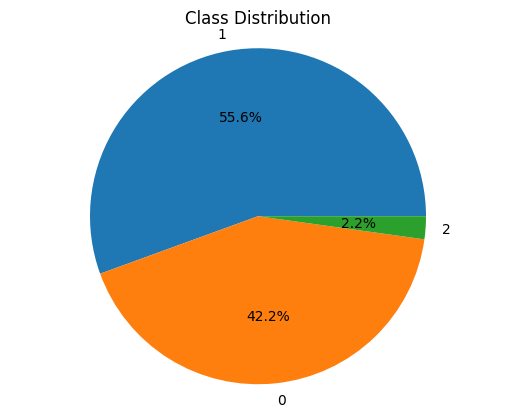

In [7]:
# or you can get a bunch of indexlists that keeps the original distribution first
meta['index'] = meta.index
indexset = meta[['stress_type','index','suid']]
# Split into subsets
subsets_index = dp.split_into_subsets(indexset, num_subsets=3, sortkey='stress_type')
#Display the resulting subsets
for i, subset in enumerate(subsets_index):
    dp.checkDistribution(subset['stress_type'])

word:communication; syllable: N AH0; stress_type:0; suid:322-124146-0010-0040


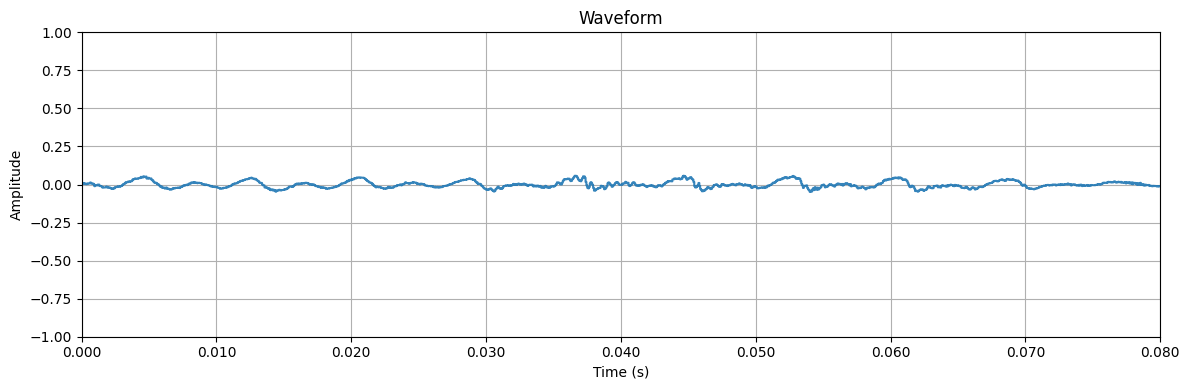

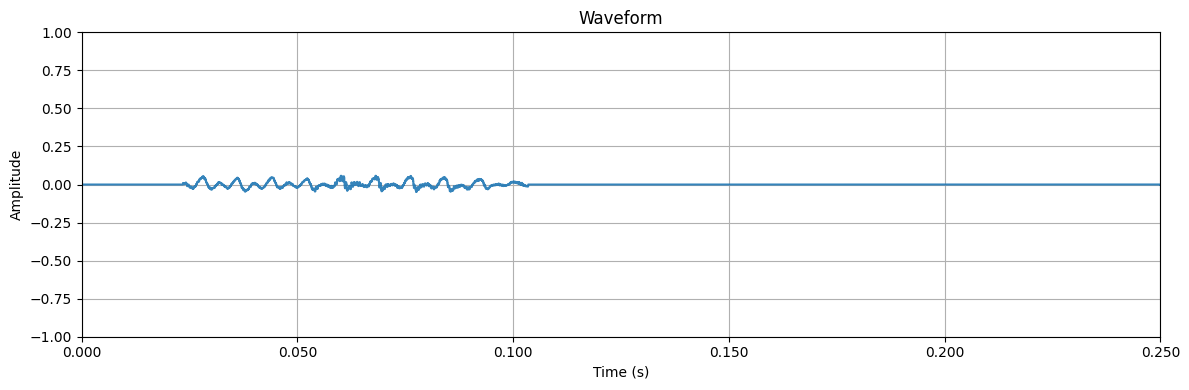

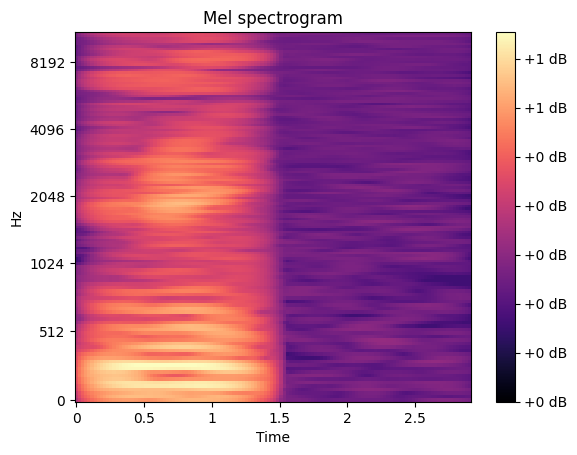

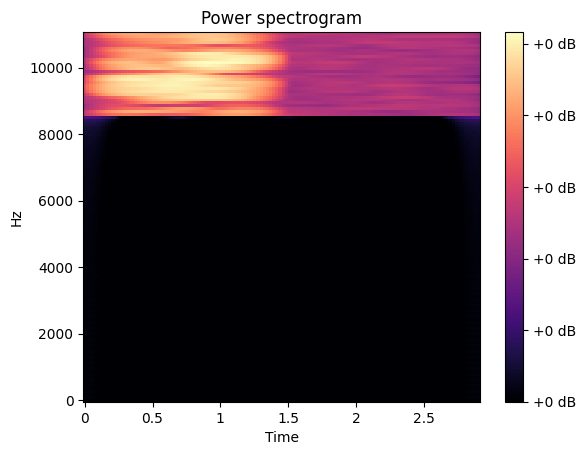

In [8]:
seed = random.randint(0,datanum)
index = indexes[seed]
word = meta['word'][index]
syllble = meta['syllable'][index]
suid = meta['suid'][index]
stress_type = meta['stress_type'][index]
print(f'word:{word}; syllable: {syllble}; stress_type:{stress_type}; suid:{suid}')
sound,sr = ap.load_file(meta['filepath'][index])
ap.visualize_waveform(sound,sr)
padded = padded_waves[index]
ap.visualize_waveform(padded,sr)
ap.visualize_mel(mels[seed])
ap.visualize_spectrogram(spectrograms[seed])

# Normalization Pretest 
(not need to run this)


In [ ]:
import numpy as np

# Parameters
sample_rate = 16000  # Samples per second
duration = 0.25       # Duration in seconds
frequency = 1000     # Frequency of the tone in Hertz

# Generate the time axis
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
# Generate the audio signal (sine wave)
audio_signal = np.sin(2 * np.pi * frequency * t)
audio_signal /= np.max(np.abs(audio_signal))  # This ensures max amplitude is 1
#silence = np.zeros(int(sample_rate * duration))+2e-5

padded_waves += [audio_signal]

## check ceiling and floor for spectrogram

In [ ]:
chunk_size = 5000
max_dB = None
min_dB = None
# Process in chunks
for start in range(0, len(padded_waves), chunk_size):
    end = min(start + chunk_size, len(padded_waves))
    chunk = padded_waves[start:end]
    # Convert the chunk
    chunk_spectrogram = [ap.wav_to_spectrogram(sound) for sound in chunk]
    chunk_spectrogram = np.array(chunk_spectrogram)
    chunk_max = np.max(chunk_spectrogram)
    chunk_min = np.min(chunk_spectrogram)
    if max_dB is None or chunk_max > max_dB:
        max_dB = chunk_max
    if min_dB is None or chunk_min < min_dB:
        min_dB = chunk_min
print(max_dB,'   ', min_dB)

#based on test dataset, max dB for spectrogram is 147.28614807128906, min is -6.0206074714660645

## check ceiling and floor for mel spectrogram

In [ ]:
chunk_size = 5000
max_dB = None
min_dB = None
# Process in chunks
for start in range(0, len(padded_waves), chunk_size):
    end = min(start + chunk_size, len(padded_waves))
    chunk = padded_waves[start:end]
    # Convert the chunk
    chunk_spectrogram = [ap.wav_to_mel_spectrogram(sound) for sound in chunk]
    chunk_spectrogram = np.array(chunk_spectrogram)
    chunk_max = np.max(chunk_spectrogram)
    chunk_min = np.min(chunk_spectrogram)
    if max_dB is None or chunk_max > max_dB:
        max_dB = chunk_max
    if min_dB is None or chunk_min < min_dB:
        min_dB = chunk_min
print(max_dB,'   ', min_dB)
#based on test dataset, max dB for mel spectrogram is 128.88963741610183, min is -6.0206074714660645

# Task for Shuhao

1.  repeat the whole process for guide_validation.csv

Note: 
There's no new method that you need to develop, unless you find some problems, if so, talk to us first. Basically, what you need to do is to learn the preprocess procudure and replicate it. 



# Meta Data process

## import packages

In [1]:
import os
import numpy as np
import audioPreprocess as ap
import random
import dataPreprocess as dp

## set parameters

In [2]:
## there are three csv files that need to be processed; guide_train.csv, guide_test.csv,guide_validation.csv
soundfolder = '/mnt/storage/compling/proslearn/src/eng/train-clean-100-cs'# where original sound files are stored
sourcefolder = '/mnt/storage/compling/proslearn/src/eng'
test_csvpath = r'/mnt/storage/compling/proslearn/src/eng/guide_validation.csv'  

## define result files' names
meta_path = test_csvpath.replace('.csv','_syllableInfor.pkl')
waves_path = test_csvpath.replace('.csv','_waves.pkl')
padded_waves_path = test_csvpath.replace('.csv','_waves_padded.pkl')
lowpass_waves_path = test_csvpath.replace('.csv','_waves_lowpass.pkl')
highpass_waves_path = test_csvpath.replace('.csv','_waves_highpass.pkl')
spectrogram_folder = soundfolder.replace('train-clean-100-cs','spectrograms')
os.makedirs(spectrogram_folder, exist_ok=True)
mel_folder = soundfolder.replace('train-clean-100-cs','mels')
os.makedirs(mel_folder, exist_ok=True)
lowpass_spectrogram_folder = soundfolder.replace('train-clean-100-cs','lowpass_spectrograms')
os.makedirs(lowpass_spectrogram_folder, exist_ok=True)
highpass_spectrogram_folder = soundfolder.replace('train-clean-100-cs','highpass_spectrograms')
os.makedirs(highpass_spectrogram_folder, exist_ok=True)
lowpass_mel_folder = soundfolder.replace('train-clean-100-cs','lowpass_mels')
os.makedirs(lowpass_mel_folder, exist_ok=True)
highpass_mel_folder = soundfolder.replace('train-clean-100-cs','highpass_mels')
os.makedirs(highpass_mel_folder, exist_ok=True)

In [3]:
spec_max_dB = 147.28614807128906 
spec_min_dB =  -6.0206074714660645
mel_max_dB = 128.88963741610183
mel_min_dB = -6.0206074714660645

## modify meta data

In [4]:
# load csv
test_data = dp.load_csv(test_csvpath)

In [5]:
# generate syllable based dataframe
# test_data.columns
selectcols = ['word', 'stress_type','syllable', 'syllable_id',
       'syllable_startTime', 'syllable_endTime',
       'syllable_path', 'suid']
test_data = test_data[selectcols]

In [6]:
# remove SNA stress_type
test_data = test_data[test_data['stress_type'] != 'SNA']

In [7]:
# remove duplicated rows
test_data = test_data.drop_duplicates(ignore_index=True)

In [8]:
test_data['filepath'] = test_data['syllable_path'].apply(lambda x: os.path.join(soundfolder, x))
print('Before dropping: ',test_data.shape)

Before dropping:  (142174, 9)


In [9]:
# drop rows where the sound file doesn't exist
test_data = test_data[test_data['filepath'].apply(lambda x: os.path.exists(x))]
test_data.reset_index(drop=True, inplace=True)
print('After dropping: ',test_data.shape)

After dropping:  (142170, 9)


## save modified meta data

In [10]:
dp.save_dataset(test_data,meta_path)

# Audio process

## get sample rate

In [11]:
test_data = dp.load_dataset(meta_path)

In [12]:
sound, sr = ap.load_file(test_data['filepath'][0])

## load all audio files 

In [13]:
waves = [ap.load_file(file)[0] for file in test_data['filepath']]
print(len(waves))

142170


## waveforms

### unpadded waves

In [14]:
# # save unpadded waves
# dp.save_dataset(waves,waves_path) # a list is saved

### padded waves

In [15]:
def padder_waveform(sound, sample_rate=16000, pad_len_ms=250, noise_level=0.001) -> np.ndarray:
    '''
    Random pad a waveform (mono) to fixed length
    :param sound: waveform
    :param sample_rate:
    :param pad_len_ms: target length of padded waveform
    :param noise_level: the sound will be padded with noise
    :return: padded waveform
    '''
    pad_len_frame = sample_rate // 1000 * pad_len_ms
    sound_len = len(sound)
    if sound_len > pad_len_frame:
        try:
            sig = sound[:pad_len_frame]
        except:
            print(sound)
            print(pad_len_frame)
            input()

    elif sound_len < pad_len_frame:
        # Length of padding to add at the beginning and end of the signal
        pad_begin_len = random.randint(0, pad_len_frame - sound_len)
        pad_end_len = pad_len_frame - sound_len - pad_begin_len

        # Pad with 0s
        # pad_begin = torch.zeros((num_rows, pad_begin_len))
        # pad_end = torch.zeros((num_rows, pad_end_len))
        pad_begin = np.random.randn(pad_begin_len) * noise_level
        pad_end = np.random.randn(pad_end_len) * noise_level

        sig = np.concatenate((pad_begin, sound, pad_end))
    else:
        sig =sound
    return sig

In [16]:
# pad waves
padded_waves = [padder_waveform(wave,sample_rate=sr,pad_len_ms=250,noise_level=1e-4) for wave in waves]

In [17]:
suids = list(test_data['suid'])

In [18]:
# save pad waves
dp.save_dataset((suids,padded_waves),padded_waves_path) # a list is saved

In [19]:
del waves

## waveform to (mel-)spectrogram
### convert to spectrogram

In [20]:
#load padded wave
suids,padded_waves = dp.load_dataset(padded_waves_path)

cloaking
K IH0 NG
0


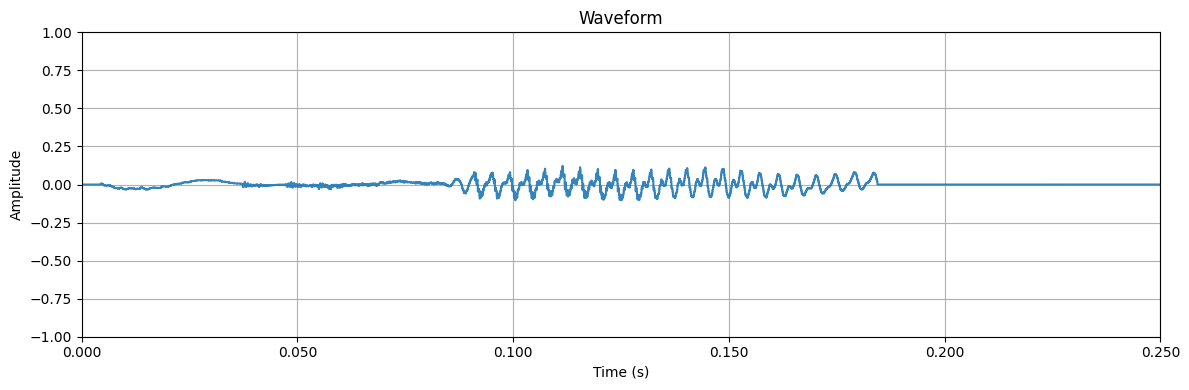

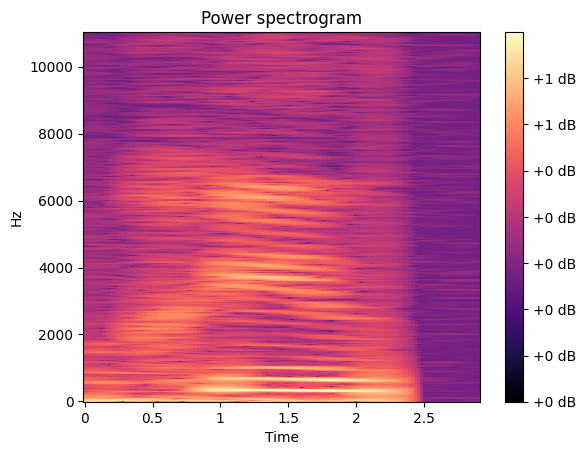

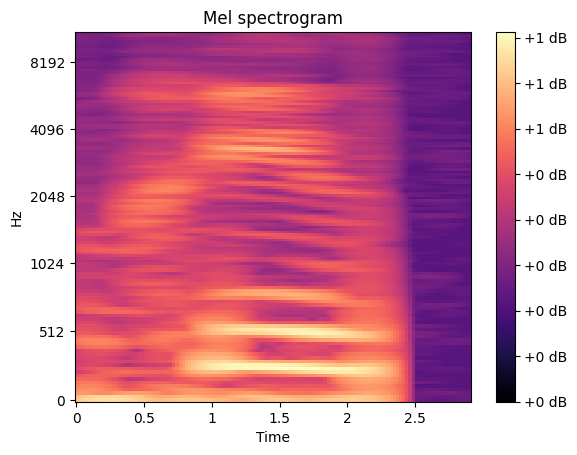

In [21]:
# this is a single process sample
sr = 16000
seed = random.randint(0,len(padded_waves))
print(test_data['word'][seed])
print(test_data['syllable'][seed])
print(test_data['stress_type'][seed])
sound = padded_waves[seed]
ap.visualize_waveform(sound,sr)
spectrogram = ap.wav_to_spectrogram(sound)
spectrogram = dp.fixed_min_max_normalization(spectrogram,min = spec_min_dB, max = spec_max_dB)
ap.visualize_spectrogram(spectrogram)
mel = ap.wav_to_mel_spectrogram(sound)
mel = dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB)
ap.visualize_mel(mel)

In [22]:
test_data['spectrogram_path'] = test_data['suid'].apply(lambda x: os.path.join(spectrogram_folder,x+'.npy'))
dp.save_dataset(test_data,meta_path)
print(test_data['spectrogram_path'][4])

/mnt/storage/compling/proslearn/src/eng/spectrograms/103-1240-0000-0005.npy


In [23]:
chunk_size = 5000
# Process in chunks
for start in range(0, len(padded_waves), chunk_size):
    end = min(start + chunk_size, len(padded_waves))
    chunk = padded_waves[start:end]
    pathlist = list(test_data['spectrogram_path'][start:end])
    # Convert the chunk
    chunk_spectrogram = [ap.wav_to_spectrogram(sound) for sound in chunk]
    # Normalize the chunk
    normalized_chunk = [dp.fixed_min_max_normalization(spectrogram,min = spec_min_dB, max = spec_max_dB) for spectrogram in chunk_spectrogram]
    # Save converted spectrograms
    dp.save_multiple_arrays(normalized_chunk,pathlist)
    print(f'processed {end}/{len(padded_waves)}')

processed 5000/142170
processed 10000/142170
processed 15000/142170
processed 20000/142170
processed 25000/142170
processed 30000/142170
processed 35000/142170
processed 40000/142170
processed 45000/142170
processed 50000/142170
processed 55000/142170
processed 60000/142170
processed 65000/142170
processed 70000/142170
processed 75000/142170
processed 80000/142170
processed 85000/142170
processed 90000/142170
processed 95000/142170
processed 100000/142170
processed 105000/142170
processed 110000/142170
processed 115000/142170
processed 120000/142170
processed 125000/142170
processed 130000/142170
processed 135000/142170
processed 140000/142170
processed 142170/142170


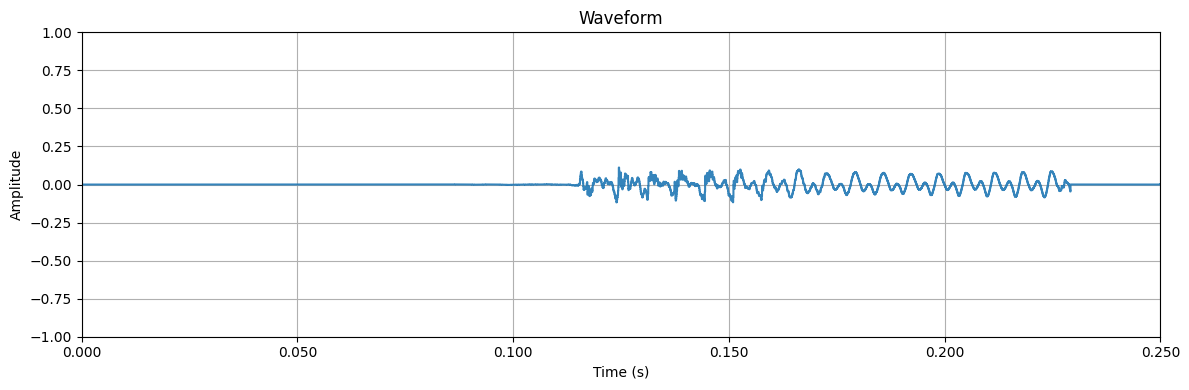

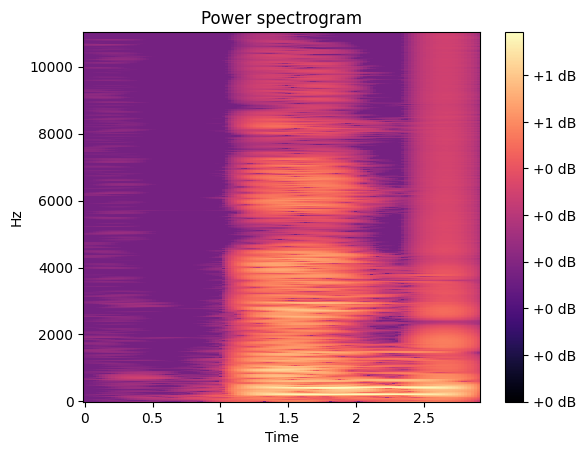

In [24]:
# check normalized data and original waveform
seed = random.randint(0,len(padded_waves))
wave = padded_waves[seed]
ap.visualize_waveform(wave,sr)
spectrogram = np.load(test_data['spectrogram_path'][seed])
ap.visualize_spectrogram(spectrogram)

In [25]:
# delete used variables after saving to free space
del chunk,normalized_chunk,chunk_spectrogram

### convert waveform to mel-spectrogram

In [26]:
test_data['mel_path'] = test_data['suid'].apply(lambda x: os.path.join(mel_folder,x+'.npy'))
dp.save_dataset(test_data,meta_path)
print(test_data['mel_path'][4])

/mnt/storage/compling/proslearn/src/eng/mels/103-1240-0000-0005.npy


In [27]:
chunk_size = 5000
# Process in chunks
for start in range(0, len(padded_waves), chunk_size):
    end = min(start + chunk_size, len(padded_waves))
    chunk = padded_waves[start:end]
    pathlist = list(test_data['mel_path'][start:end])
    # Convert the chunk
    chunk_mel = [ap.wav_to_mel_spectrogram(sound) for sound in chunk]
    # Normalize the chunk
    normalized_chunk = [dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB) for mel in chunk_mel]
    # Save converted spectrograms
    dp.save_multiple_arrays(normalized_chunk,pathlist)
    print(f'processed {end}/{len(padded_waves)}')

processed 5000/142170
processed 10000/142170
processed 15000/142170
processed 20000/142170
processed 25000/142170
processed 30000/142170
processed 35000/142170
processed 40000/142170
processed 45000/142170
processed 50000/142170
processed 55000/142170
processed 60000/142170
processed 65000/142170
processed 70000/142170
processed 75000/142170
processed 80000/142170
processed 85000/142170
processed 90000/142170
processed 95000/142170
processed 100000/142170
processed 105000/142170
processed 110000/142170
processed 115000/142170
processed 120000/142170
processed 125000/142170
processed 130000/142170
processed 135000/142170
processed 140000/142170
processed 142170/142170


In [ ]:
seed = random.randint(0,len(padded_waves))
wave = padded_waves[seed]
ap.visualize_waveform(wave,sr)
mel = np.load(test_data['mel_path'][seed])
ap.visualize_mel(mel)

In [ ]:
del chunk,chunk_mel,normalized_chunk

## high/low filter

In [ ]:
# get a sample
seed = random.randint(0,len(padded_waves))
print(test_data['syllable'][seed])
sound = padded_waves[seed]
ap.visualize_waveform(sound,sr)
spectrogram = ap.wav_to_spectrogram(sound)
spectrogram = dp.fixed_min_max_normalization(spectrogram,min = spec_min_dB, max = spec_max_dB)
ap.visualize_spectrogram(spectrogram)
mel = ap.wav_to_mel_spectrogram(sound)
mel = dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB)
ap.visualize_mel(mel)

### low pass

In [ ]:
sound_low = ap.lowpass_filter(sound,sr,cut_off_upper=500,cut_off_lower=0)
ap.visualize_waveform(sound_low,sr)
S = ap.wav_to_spectrogram(sound_low)
S = dp.fixed_min_max_normalization(S,min = spec_min_dB, max = spec_max_dB)
mel = ap.wav_to_mel_spectrogram(sound_low,sr)
mel = dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB)
ap.visualize_spectrogram(S)
ap.visualize_mel(mel)

In [ ]:
lowpassed = [ap.lowpass_filter(sound,sr,cut_off_upper=500,cut_off_lower=0) for sound in padded_waves]

In [ ]:
dp.save_dataset((suids,lowpassed),lowpass_waves_path) 

In [ ]:
del lowpassed

#### convert to spec

In [ ]:
test_data['lowpass_spectrogram_path'] = test_data['suid'].apply(lambda x: os.path.join(lowpass_spectrogram_folder, x + '.npy'))
dp.save_dataset(test_data, meta_path)
print(test_data['lowpass_spectrogram_path'][4])

In [ ]:
suid,lowpassed = dp.load_dataset(lowpass_waves_path)

In [ ]:
# get a sample
seed = random.randint(0,len(lowpassed))
print(test_data['syllable'][seed])
sound = lowpassed[seed]
ap.visualize_waveform(sound,sr)
spectrogram = ap.wav_to_spectrogram(sound)
spectrogram = dp.fixed_min_max_normalization(spectrogram,min = spec_min_dB, max = spec_max_dB)
ap.visualize_spectrogram(spectrogram)
mel = ap.wav_to_mel_spectrogram(sound)
mel = dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB)
ap.visualize_mel(mel)

In [ ]:
chunk_size = 5000
# Process in chunks
for start in range(0, len(lowpassed), chunk_size):
    end = min(start + chunk_size, len(lowpassed))
    chunk = lowpassed[start:end]
    pathlist = list(test_data['lowpass_spectrogram_path'][start:end])
    # Convert the chunk
    chunk_spectrogram = [ap.wav_to_spectrogram(sound) for sound in chunk]
    # Normalize the chunk
    normalized_chunk = [dp.fixed_min_max_normalization(spectrogram, min=spec_min_dB, max=spec_max_dB) for spectrogram in
                        chunk_spectrogram]
    # Save converted spectrograms
    dp.save_multiple_arrays(normalized_chunk, pathlist)
    print(f'processed {end}/{len(lowpassed)}')

In [ ]:
# check normalized data and original waveform
seed = random.randint(0,len(lowpassed))
wave = lowpassed[seed]
ap.visualize_waveform(wave,sr)
spectrogram = np.load(test_data['lowpass_spectrogram_path'][seed])
ap.visualize_spectrogram(spectrogram)

In [ ]:
# delete used variables after saving to free space
del chunk,normalized_chunk,chunk_spectrogram

#### conver to mel

In [ ]:
test_data['lowpass_mel_path'] = test_data['suid'].apply(lambda x: os.path.join(lowpass_mel_folder,x+'.npy'))
dp.save_dataset(test_data,meta_path)
print(test_data['lowpass_mel_path'][4])

In [ ]:
chunk_size = 5000
# Process in chunks
for start in range(0, len(lowpassed), chunk_size):
    end = min(start + chunk_size, len(lowpassed))
    chunk = lowpassed[start:end]
    pathlist = list(test_data['lowpass_mel_path'][start:end])
    # Convert the chunk
    chunk_mel = [ap.wav_to_mel_spectrogram(sound) for sound in chunk]
    # Normalize the chunk
    normalized_chunk = [dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB) for mel in chunk_mel]
    # Save converted spectrograms
    dp.save_multiple_arrays(normalized_chunk,pathlist)
    print(f'processed {end}/{len(lowpassed)}')

In [ ]:
# check normalized data and original waveform
seed = random.randint(0,len(lowpassed))
wave = lowpassed[seed]
ap.visualize_waveform(wave,sr)
mel = np.load(test_data['lowpass_mel_path'][seed])
ap.visualize_mel(mel)

In [ ]:
del chunk,normalized_chunk

In [ ]:
del lowpassed,chunk_mel

### high pass

In [ ]:
highpassed = [ap.lowpass_filter(sound,sr,cut_off_upper=int(sr/2),cut_off_lower=4000) for sound in padded_waves]

In [ ]:
dp.save_dataset((suids,highpassed),highpass_waves_path)

In [ ]:
del highpassed

#### convert to spec

In [ ]:
test_data['highpass_spectrogram_path'] = test_data['suid'].apply(lambda x: os.path.join(highpass_spectrogram_folder, x + '.npy'))
dp.save_dataset(test_data, meta_path)
print(test_data['highpass_spectrogram_path'][4])

In [ ]:
suid,highpassed = dp.load_dataset(highpass_waves_path)

In [ ]:
# get a sample
seed = random.randint(0,len(highpassed))
print(test_data['syllable'][seed])
sound = highpassed[seed]
ap.visualize_waveform(sound,sr)
spectrogram = ap.wav_to_spectrogram(sound)
spectrogram = dp.fixed_min_max_normalization(spectrogram,min = spec_min_dB, max = spec_max_dB)
ap.visualize_spectrogram(spectrogram)
mel = ap.wav_to_mel_spectrogram(sound)
mel = dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB)
ap.visualize_mel(mel)

In [ ]:
chunk_size = 5000
# Process in chunks
for start in range(0, len(highpassed), chunk_size):
    end = min(start + chunk_size, len(highpassed))
    chunk = highpassed[start:end]
    pathlist = list(test_data['highpass_spectrogram_path'][start:end])
    # Convert the chunk
    chunk_spectrogram = [ap.wav_to_spectrogram(sound) for sound in chunk]
    # Normalize the chunk
    normalized_chunk = [dp.fixed_min_max_normalization(spectrogram, min=spec_min_dB, max=spec_max_dB) for spectrogram in
                        chunk_spectrogram]
    # Save converted spectrograms
    dp.save_multiple_arrays(normalized_chunk, pathlist)
    print(f'processed {end}/{len(highpassed)}')

In [ ]:
# check normalized data and original waveform
seed = random.randint(0,len(highpassed))
wave = highpassed[seed]
ap.visualize_waveform(wave,sr)
spectrogram = np.load(test_data['highpass_spectrogram_path'][seed])
ap.visualize_spectrogram(spectrogram)
# delete used variables after saving to free space

In [ ]:
del chunk,normalized_chunk,chunk_spectrogram

#### convert to mel

In [ ]:
test_data['highpass_mel_path'] = test_data['suid'].apply(lambda x: os.path.join(highpass_mel_folder,x+'.npy'))
dp.save_dataset(test_data,meta_path)
print(test_data['highpass_mel_path'][4])

In [ ]:
chunk_size = 5000
# Process in chunks
for start in range(0, len(highpassed), chunk_size):
    end = min(start + chunk_size, len(highpassed))
    chunk = highpassed[start:end]
    pathlist = list(test_data['highpass_mel_path'][start:end])
    # Convert the chunk
    chunk_mel = [ap.wav_to_mel_spectrogram(sound) for sound in chunk]
    # Normalize the chunk
    normalized_chunk = [dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB) for mel in chunk_mel]
    # Save converted spectrograms
    dp.save_multiple_arrays(normalized_chunk,pathlist)
    print(f'processed {end}/{len(highpassed)}')
    

In [ ]:
# check normalized data and original waveform
seed = random.randint(0,len(highpassed))
wave = highpassed[seed]
ap.visualize_waveform(wave,sr)
mel = np.load(test_data['highpass_mel_path'][seed])
ap.visualize_mel(mel)

In [ ]:
del chunk,normalized_chunk,chunk_mel
del highpassed

# Advanced audio processing

## Adding Heart beat

Method: simulate or get sample of heart beat audio with different rate, randomly insert into the syllale (start time, rate)

## Yingfu Lingdao Jiancha

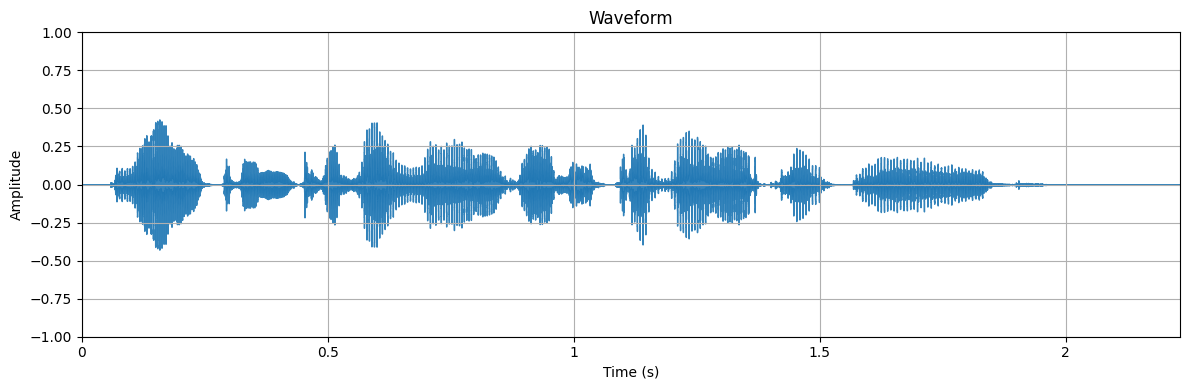

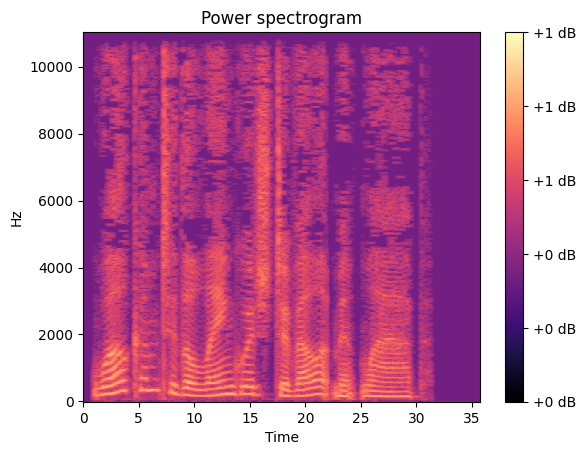

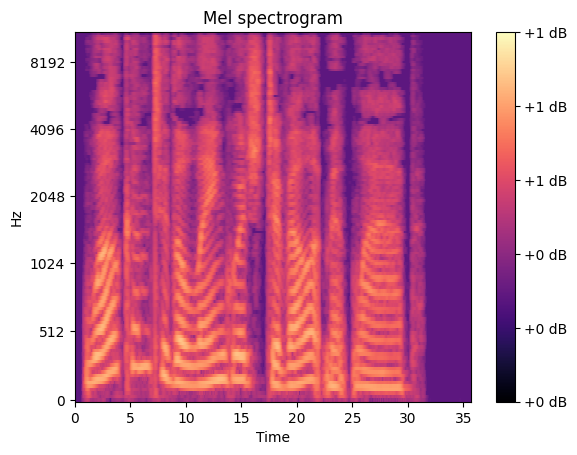

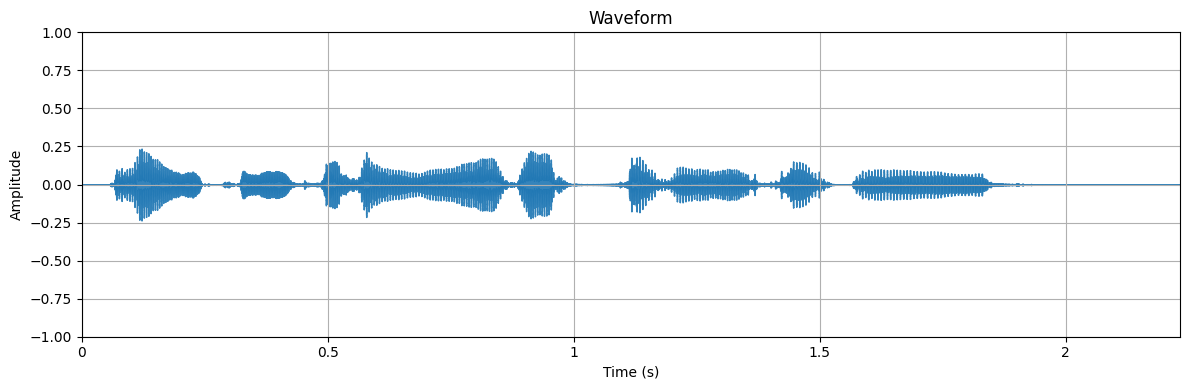

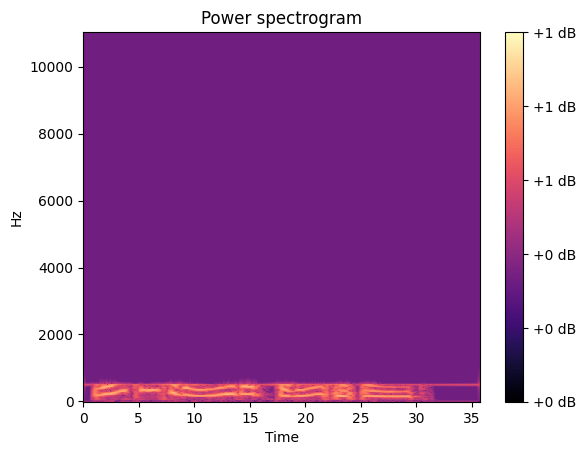

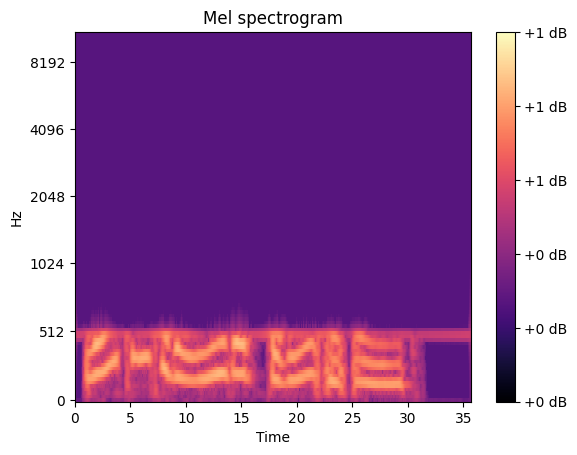

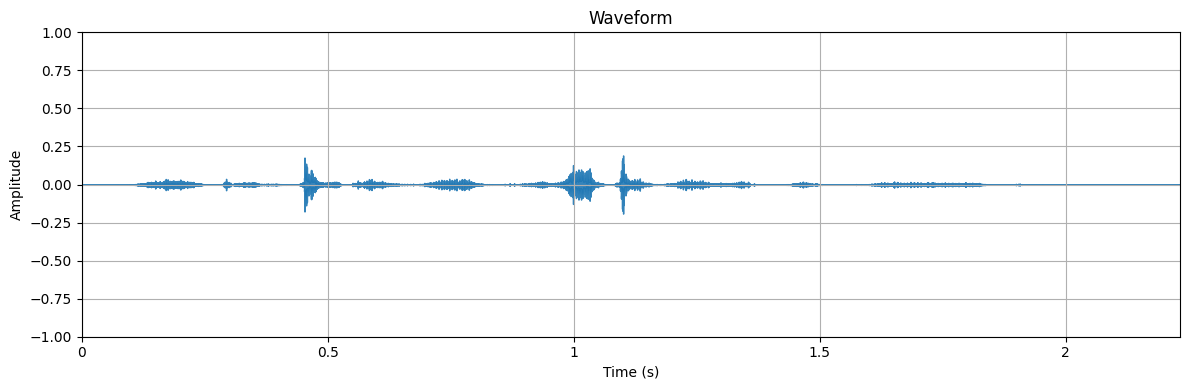

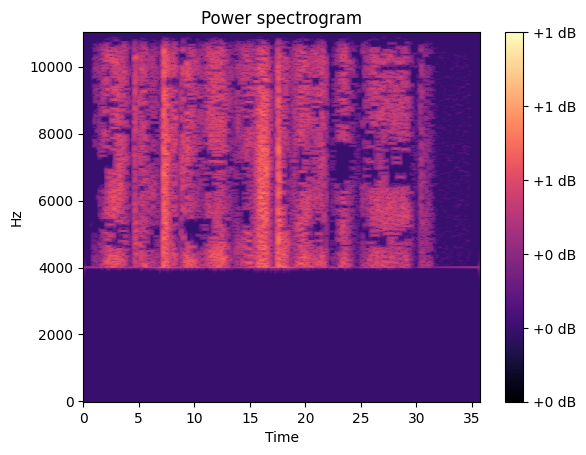

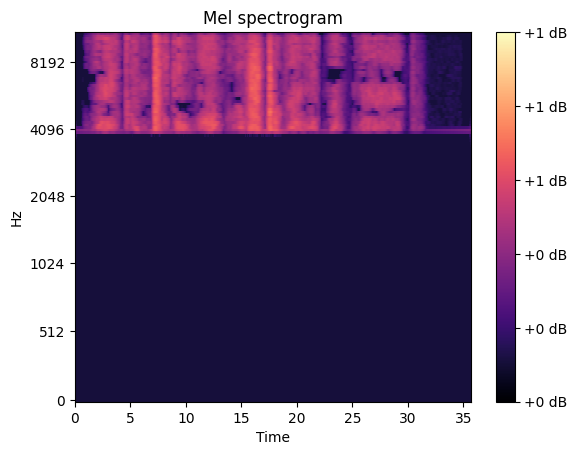

In [8]:
import librosa
import audioPreprocess as ap
import dataPreprocess as dp

spec_max_dB = 147.28614807128906 
spec_min_dB =  -6.0206074714660645
mel_max_dB = 128.88963741610183
mel_min_dB = -6.0206074714660645

sound,sr = librosa.load("soundSample.mp3")
ap.visualize_waveform(sound, sr)
spectrogram = ap.wav_to_spectrogram(sound)
spectrogram = dp.fixed_min_max_normalization(spectrogram,min = spec_min_dB, max = spec_max_dB)
ap.visualize_spectrogram(spectrogram)
mel = ap.wav_to_mel_spectrogram(sound)
mel = dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB)
ap.visualize_mel(mel)

sound_low = ap.lowpass_filter(sound,sr,cut_off_upper=500,cut_off_lower=0)
ap.visualize_waveform(sound_low,sr)
S = ap.wav_to_spectrogram(sound_low)
S = dp.fixed_min_max_normalization(S,min = spec_min_dB, max = spec_max_dB)
mel = ap.wav_to_mel_spectrogram(sound_low,sr)
mel = dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB)
ap.visualize_spectrogram(S)
ap.visualize_mel(mel)




sound_high = ap.lowpass_filter(sound,sr,cut_off_upper=int(sr/2),cut_off_lower=4000)
ap.visualize_waveform(sound_high,sr)
S = ap.wav_to_spectrogram(sound_high)
S = dp.fixed_min_max_normalization(S,min = spec_min_dB, max = spec_max_dB)
mel = ap.wav_to_mel_spectrogram(sound_high,sr)
mel = dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB)
ap.visualize_spectrogram(S)
ap.visualize_mel(mel)



In [10]:
import soundfile as sf

sf.write('soundSample_lowfiltered.mp3',sound_low,sr)
sf.write('soundSample_highfiltered.mp3',sound_high,sr)